In [1]:
# @title Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

# Set seed for reproducibility
SEED = 47
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# @title Load & Preprocess Data
def load_and_preprocess():
    # Load data
    df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [3]:
# @title Data Engineering
# Load the data again since it was redefined previously
df = pd.read_csv('marketing_campaign.csv', sep='\t')

# Print column names to check if it exists
#print(df.columns)

print("Number of unique values in Z_CostContact column:", df['Z_CostContact'].nunique())
print("Number of unique values in Z_Revenue column:", df["Z_Revenue"].nunique())

# Remove unnecessary columns ('Id' and columns with 1 unique value)
df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

# Standardize 'Marital_Status' into 2 broader groups
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'], 'Partner')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'], 'Single')

# Standardize 'Education' into 3 broader groups
df['Education'] = df['Education'].replace(['PhD', 'Master'], 'Postgraduate')
df['Education'] = df['Education'].replace(['2n Cycle', 'Graduation'], 'Graduate')
df['Education'] = df['Education'].replace(['Basic'], 'Undergraduate')

# Define categorical_columns here
categorical_columns = ['Education', 'Marital_Status']

for column in categorical_columns:
    print(f"Unique values in {column}:")
    print(df[column].unique())
    print("\n")

# Combining columns together to reduce the number of dimensions
df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['TotalNumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

# Converting date to numerical variable by calculating duration
data = df.copy()

# Calculate 'Days_as_client' before selecting columns
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
latest_date = df['Dt_Customer'].max()
df['Days_as_client'] = (latest_date - df['Dt_Customer']).dt.days
df.head()

df = df[['Education', 'Marital_Status', 'Income', 'Kids', 'Days_as_client', 'Recency', 'Expenses',
         'TotalNumPurchases', 'TotalAcceptedCmp', 'Complain', 'Response']]



Number of unique values in Z_CostContact column: 1
Number of unique values in Z_Revenue column: 1
Unique values in Education:
['Graduate' 'Postgraduate' 'Undergraduate']


Unique values in Marital_Status:
['Single' 'Partner']




In [4]:
# @title Clean data
def load_and_preprocess():
    # Load data
    df = pd.read_csv('marketing_campaign.csv', sep='\t')
    df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)
    df['Income'] = df['Income'].fillna(df['Income'].median())
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
    latest_date = df['Dt_Customer'].max()
    df['Tenure'] = (latest_date - df['Dt_Customer']).dt.days
    df = df.drop('Dt_Customer', axis=1)

    # One-Hot Encoding
    return pd.get_dummies(df, columns=['Education', 'Marital_Status'])

df = load_and_preprocess()

# Categorize columns into three groups based on their data type

binary_columns = [col for col in df.columns if df[col].nunique() == 2]
categorical_columns = [col for col in df.columns if 2 < df[col].nunique() < 10]
numerical_columns = [col for col in df.select_dtypes(include=['number']).columns
                     if col not in binary_columns + categorical_columns]


In [5]:
# @title Remove missing data and outliers

import numpy as np
# Remove missing values
df = df.dropna()

# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols = df.select_dtypes(include=np.number).columns
df = remove_outliers_iqr(df, numerical_cols)


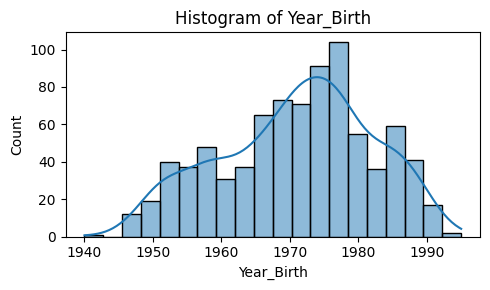

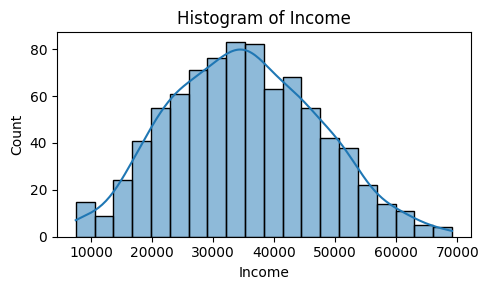

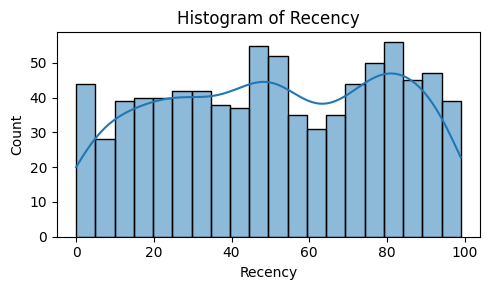

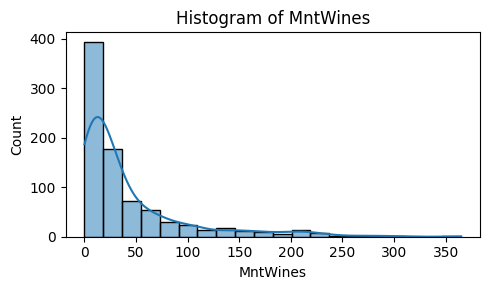

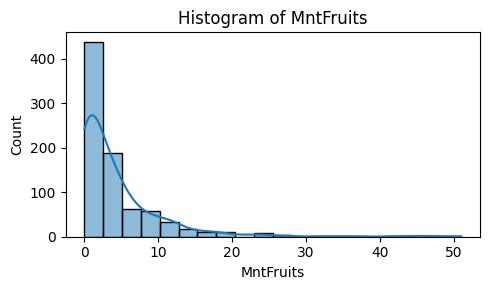

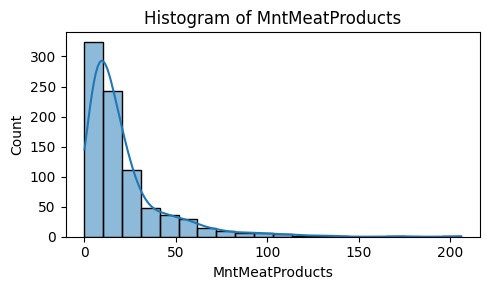

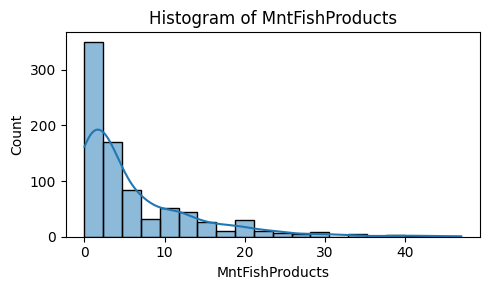

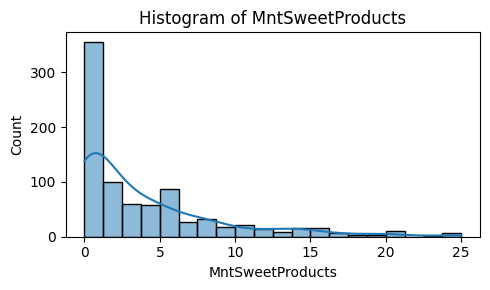

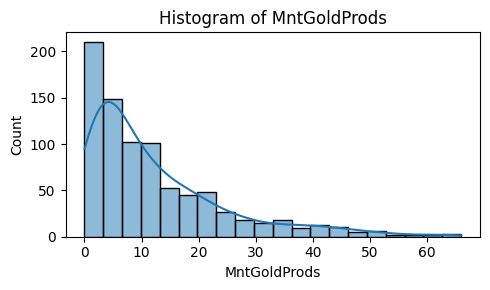

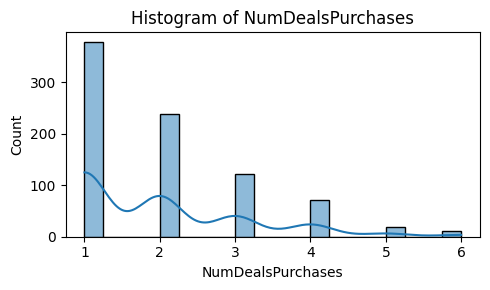

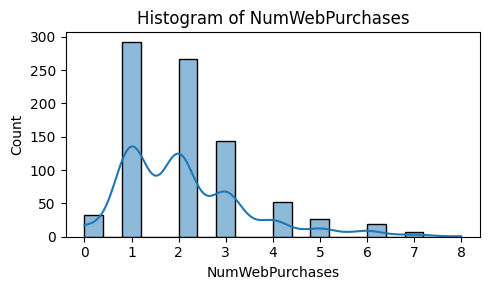

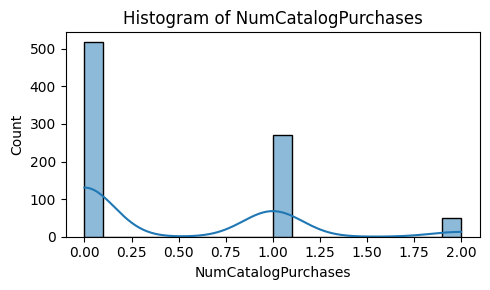

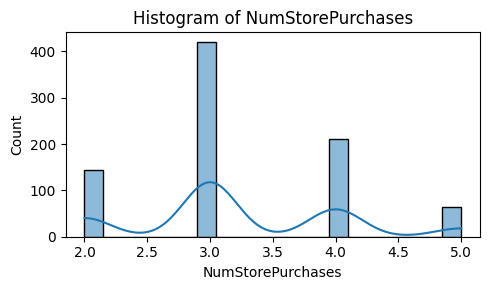

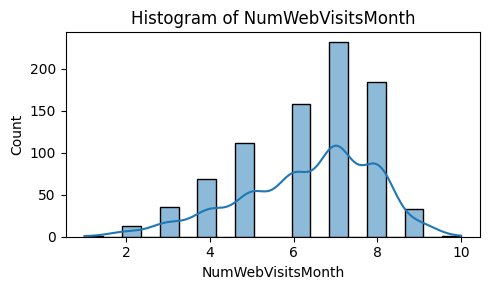

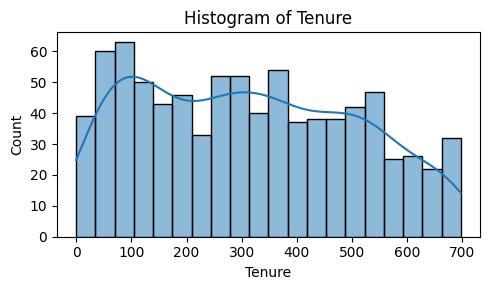

In [31]:
# @title Exploratory Data Analysis

# Plot histograms for each numerical column
for column in numerical_columns:

    plt.figure(figsize=(5, 3))
    sns.histplot(data=df, x=column, kde=True, bins=20)
    plt.title(f'Histogram of {column}')

    plt.tight_layout()
    plt.show()

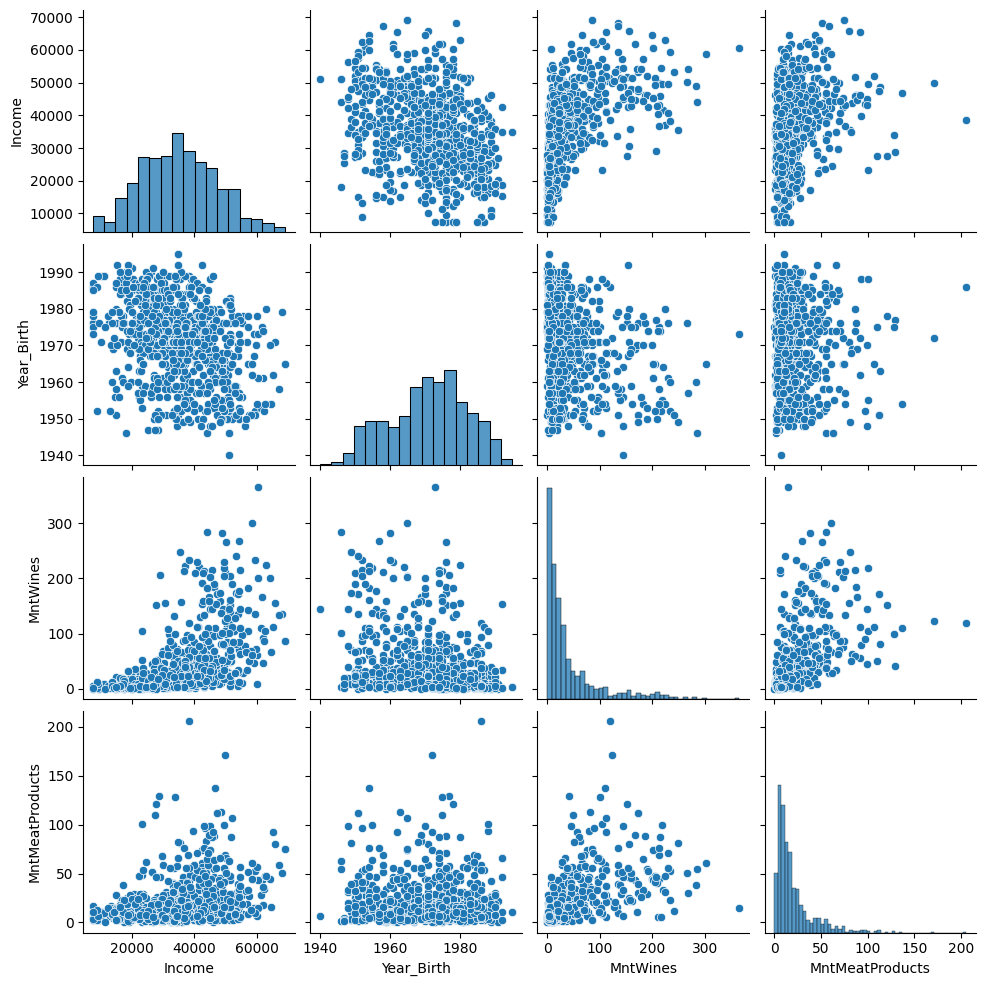

In [7]:
# @title Visualize relationships between multiple variables

sns.pairplot(df[['Income', 'Year_Birth', 'MntWines', 'MntMeatProducts']])
plt.show()

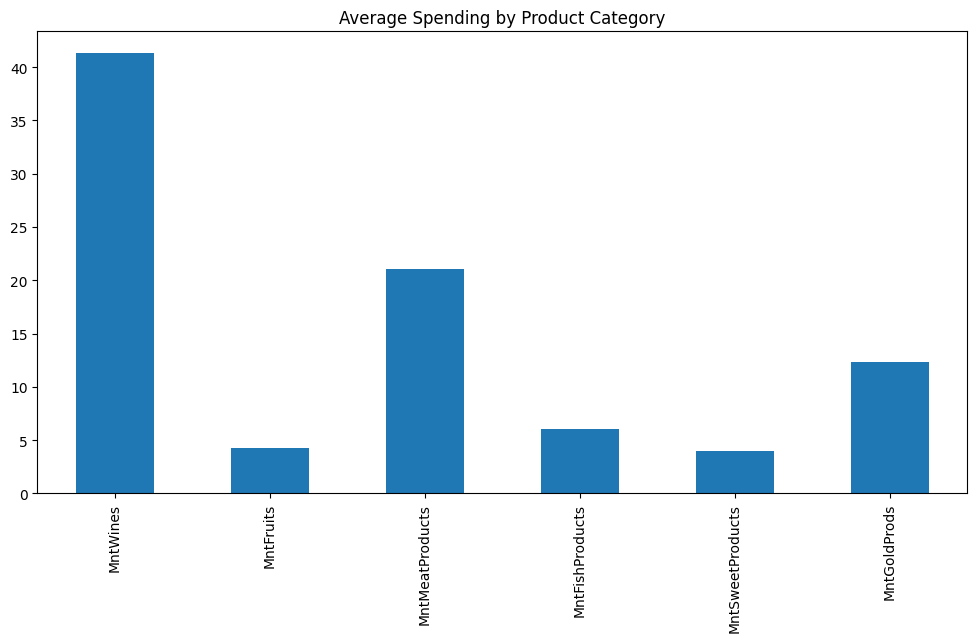

In [8]:
# @title Average Spending by Product Category
# Spending Patterns
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
plt.figure(figsize=(12,6))
df[spending_cols].mean().plot(kind='bar')
plt.title('Average Spending by Product Category')
plt.show()

In [10]:
# @title Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

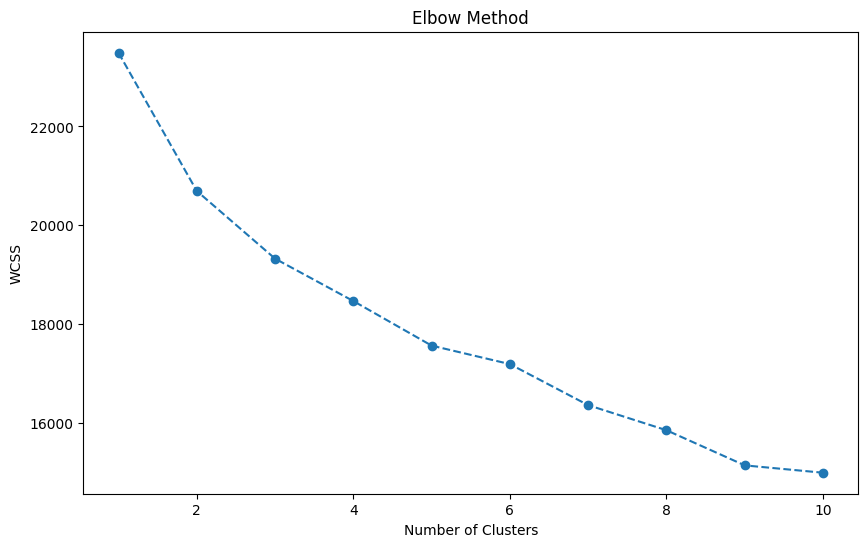

In [11]:
# @title Optimal Cluster Determination with Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

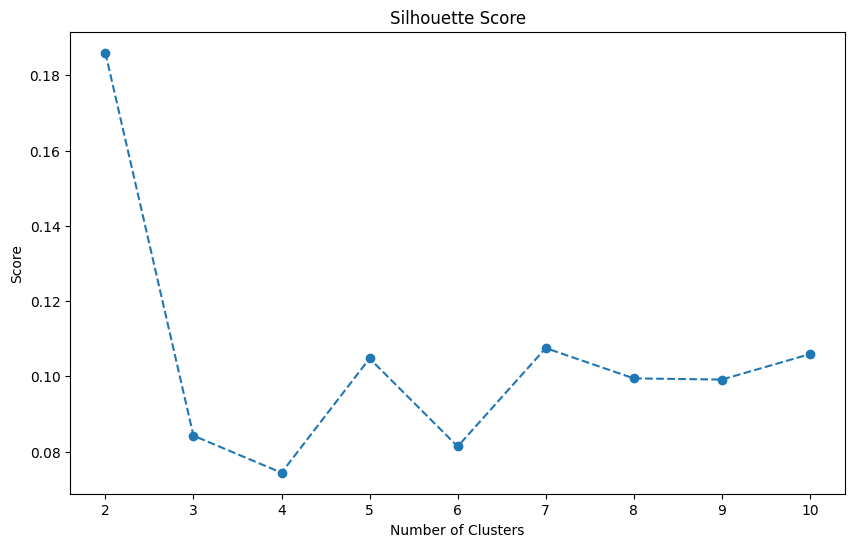

In [12]:
# @title Optimal Cluster Determination with Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(scaled_df)
    silhouette_scores.append(silhouette_score(scaled_df, clusters))

plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

K-Means Optimization:


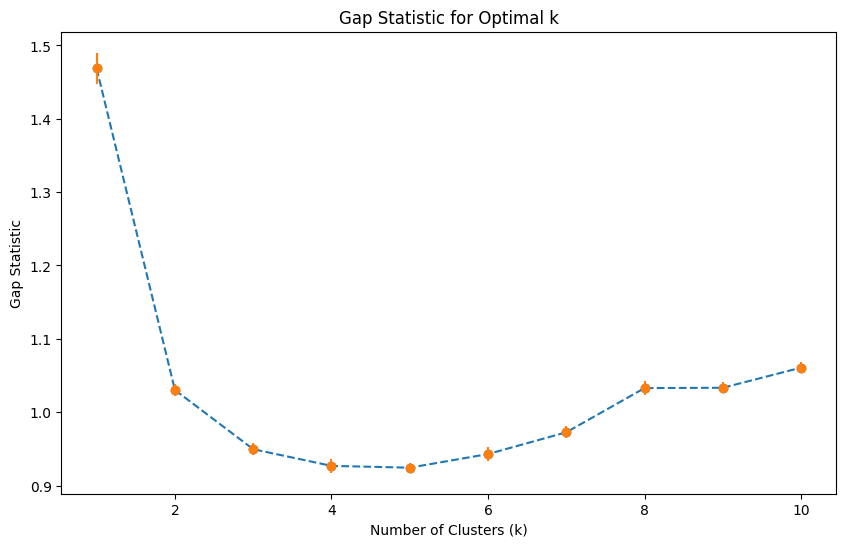

Optimal number of clusters based on Gap Statistic: 1


In [13]:
# @title Optimal Cluster Determination with Gap Statistic
def find_optimal_clusters(scaled_df):
    # K-Means Optimization
    print("K-Means Optimization:")
    wcss, silhouette_scores = [], []
    for i in range(1, 11):
        # Use the imported KMeans class here
        kmeans = KMeans(n_clusters=i, random_state=SEED).fit(scaled_df)
        wcss.append(kmeans.inertia_)
        if i >= 2:
            silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

    # Gap Statistic
    # Manual Implementation of Gap Statistic
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import pairwise_distances
    from sklearn.preprocessing import StandardScaler

    def calculate_gap_statistic(scaled_df, max_k=8, B=10):

        n = scaled_df.shape[0]
        gaps = np.zeros(max_k)
        sds = np.zeros(max_k)

        for k in range(1, max_k + 1):
            # Use the imported KMeans class, refernced with the global keyword
            kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_df)
            orig_Wk = kmeans.inertia_

            ref_Wks = []
            for _ in range(B):
                ref_data = np.random.uniform(low=scaled_df.min(), high=scaled_df.max(), size=scaled_df.shape)
                kmeans_ref = KMeans(n_clusters=k, random_state=0).fit(ref_data)
                ref_Wks.append(kmeans_ref.inertia_)

            gaps[k - 1] = np.mean(np.log(ref_Wks)) - np.log(orig_Wk)
            sds[k - 1] = np.std(np.log(ref_Wks)) * np.sqrt(1 + 1 / B)

        return gaps, sds

    # Scaled data as scaled_df
    max_k = 10
    gaps, sds = calculate_gap_statistic(scaled_df, max_k)

    # Plot the Gap Statistic
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), gaps, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic for Optimal k')
    plt.errorbar(range(1, max_k + 1), gaps, yerr=sds, fmt='o')
    plt.show()

    # Determine the optimal k (where gap(k) > gap(k+1) - s_k+1)
    optimal_k = np.argmax(gaps) + 1
    print(f"Optimal number of clusters based on Gap Statistic: {optimal_k}")

    # Return the optimal number of clusters
    return {'kmeans': {'gap': optimal_k}} # Returning a dictionary with optimal k


# Call the function and assign the result to optimal
optimal = find_optimal_clusters(scaled_df) # Call the function here

In [14]:
# @title Clustering with Stability Testing
def stable_clustering(scaled_df, n_seeds=5):
    results = {}

    # K-Means
    kmeans_results = []
    for seed in range(n_seeds):
        hashed_seed = int(hashlib.sha256(str(seed).encode()).hexdigest(), 16) % 10**8
        kmeans = KMeans(n_clusters=2, random_state=hashed_seed).fit(scaled_df)
        kmeans_results.append(kmeans.labels_)
    results['kmeans'] = kmeans_results

    # DBSCAN
    neighbors = NearestNeighbors(n_neighbors=5).fit(scaled_df)
    distances = np.sort(neighbors.kneighbors(scaled_df)[0][:, -1])
    eps = distances[np.argmax(np.diff(distances)) + 1]
    dbscan = DBSCAN(eps=eps, min_samples=5).fit(scaled_df)
    results['dbscan'] = [dbscan.labels_]  # DBSCAN is deterministic

    # Hierarchical
    agg_results = []
    for seed in range(n_seeds):
        hashed_seed = int(hashlib.sha256(str(seed).encode()).hexdigest(), 16) % 10**8
        agg = AgglomerativeClustering(n_clusters=2).fit(scaled_df)
        agg_results.append(agg.labels_)
    results['hierarchical'] = agg_results

    return results

cluster_results = stable_clustering(scaled_df)

# Cluster Stability Analysis
def calculate_stability(results):
    stability = {}
    for method, labels_list in results.items():
        scores = []
        for i in range(len(labels_list)-1):
            scores.append(adjusted_rand_score(labels_list[i], labels_list[i+1]))
        stability[method] = np.mean(scores)
    return stability

stability_scores = calculate_stability(cluster_results)
print("\nCluster Stability Scores:")
for method, score in stability_scores.items():
    print(f"{method.capitalize()}: {score:.3f}")


Cluster Stability Scores:
Kmeans: 0.873
Dbscan: nan
Hierarchical: 1.000


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
# @title Silhouette score for two cluster analysis

from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for K-Means with 2 clusters
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_clusters_3 = kmeans_3.fit_predict(scaled_df)
silhouette_avg_3 = silhouette_score(scaled_df, kmeans_clusters_3)

# Calculate Silhouette Score for DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)  # Example parameters, adjust as needed
dbscan_clusters = dbscan.fit_predict(scaled_df)
silhouette_avg_dbscan = silhouette_score(scaled_df, dbscan_clusters)


# Calculate Silhouette Score for Agglomerative Clustering with 2 clusters
agg_clustering_3 = AgglomerativeClustering(n_clusters=3, linkage='complete')
agg_clusters_3 = agg_clustering_3.fit_predict(scaled_df)
silhouette_avg_agg_3 = silhouette_score(scaled_df, agg_clusters_3)

# Print the silhouette scores
print("Silhouette Score for K-Means (2 clusters):", silhouette_avg_3)
print("Silhouette Score for DBSCAN:", silhouette_avg_dbscan)
print("Silhouette Score for Agglomerative Clustering (2 clusters):", silhouette_avg_agg_3)

Silhouette Score for K-Means (2 clusters): 0.08420609509239535
Silhouette Score for DBSCAN: -0.033189341164286824
Silhouette Score for Agglomerative Clustering (2 clusters): 0.1554321617305073


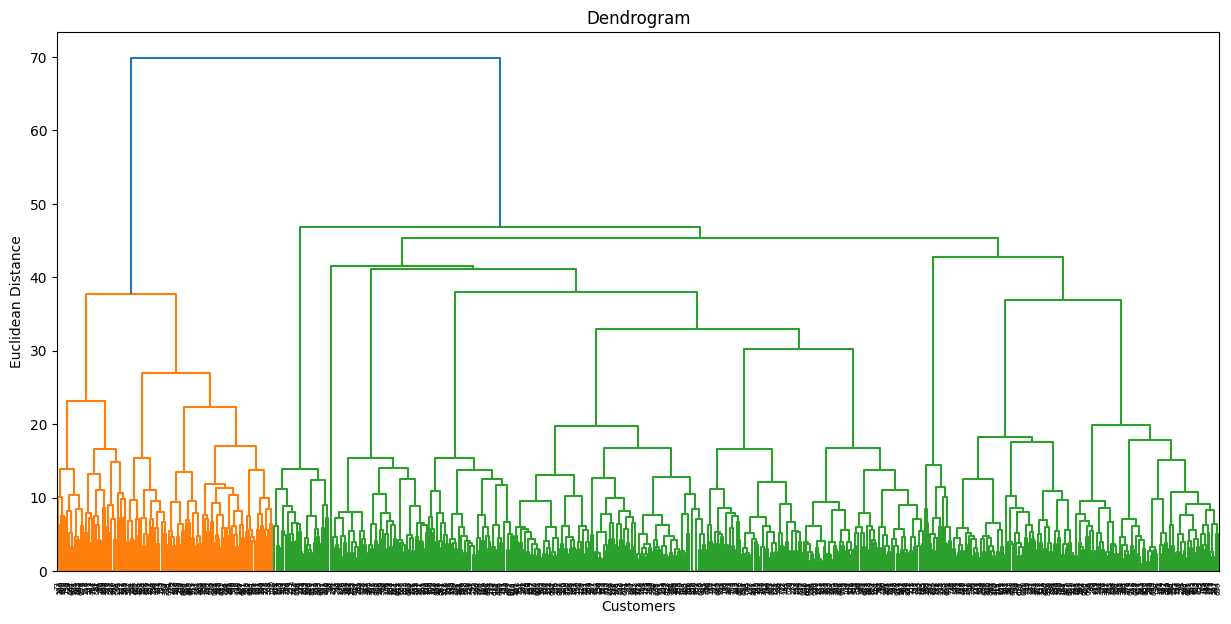

<ipython-input-16-94785195792a>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Hierarchical_Cluster'].fillna(-1, inplace=True)


In [16]:
# @title Hierarchical Clustering (Agglomerative Clustering)
# Dendrogram
plt.figure(figsize=(15, 7))
dend = dendrogram(linkage(scaled_df, method='ward'))  # Linkage method is 'ward' here
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

# Agglomerative Clustering
# If using scikit-learn version < 1.2, remove affinity='euclidean'
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')
agg_clusters = agg_clustering.fit_predict(scaled_df)

# Instead of directly assigning to df, create a new column in scaled_df
scaled_df['Hierarchical_Cluster'] = agg_clusters

# Now, merge this cluster information back to the original df
df = df.merge(scaled_df[['Hierarchical_Cluster']], left_index=True, right_index=True, how='left')

# Fill NaN values (for rows that were removed during outlier handling) with -1 or any other appropriate value
df['Hierarchical_Cluster'].fillna(-1, inplace=True)

In [17]:
# @title Cluster Characterization
def characterize_clusters(labels, method_name):
    df[f'{method_name}_Cluster'] = labels
    # Exclude the cluster label column from the mean calculation
    cluster_profile = df.drop(columns=[col for col in df.columns if '_Label' in col]).groupby(f'{method_name}_Cluster').mean()

    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])

    # Assign labels based on characteristics
    if method_name == 'kmeans':
        labels_map = {
            0: "High-Value Customers", #Big Spenders
            1: "Low-Value Customers", #Budget-Conscious Shoppers (4 cluster)"Premium Customers",
            #2: "Deal Seekers",
            #3: "Regular Shoppers"
        }
        df[f'{method_name}_Cluster_Label'] = df[f'{method_name}_Cluster'].map(labels_map)

    return cluster_profile

# Characterize all methods
for method in cluster_results.keys():
    characterize_clusters(cluster_results[method][0], method)


Kmeans Cluster Profiles:
                      Income    MntWines  MntMeatProducts  NumDealsPurchases  \
kmeans_Cluster                                                                 
0               32426.322452   20.151274        12.076433           1.689490   
1               42824.388626  104.175355        47.767773           2.867299   

                NumWebPurchases  
kmeans_Cluster                   
0                       1.58121  
1                       3.64455  

Dbscan Cluster Profiles:
                      Income   MntWines  MntMeatProducts  NumDealsPurchases  \
dbscan_Cluster                                                                
0               35041.330751  41.282479        21.052443           1.985697   

                NumWebPurchases  
dbscan_Cluster                   
0                      2.100119  

Hierarchical Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
hierarchical_Cluster                                

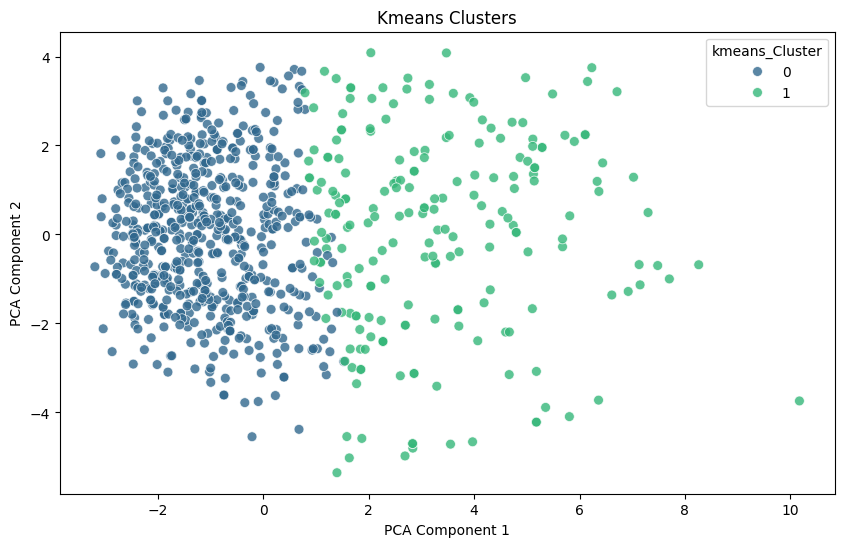

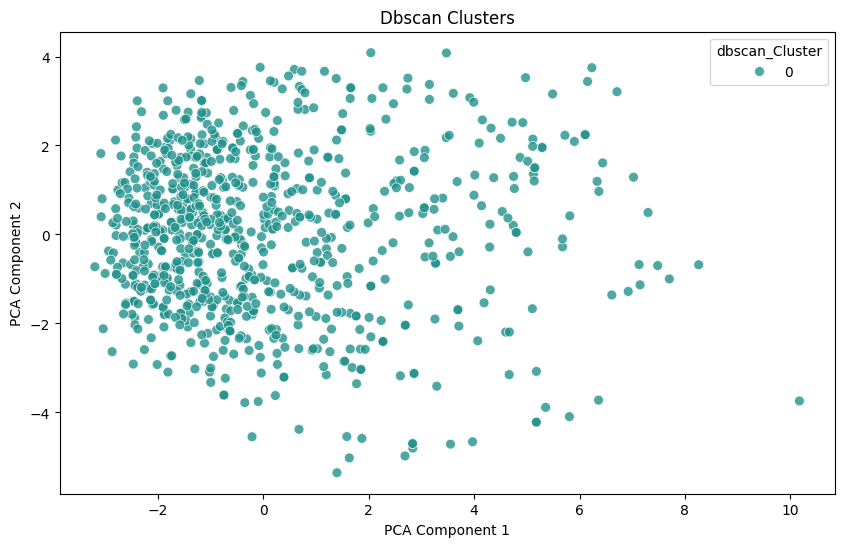

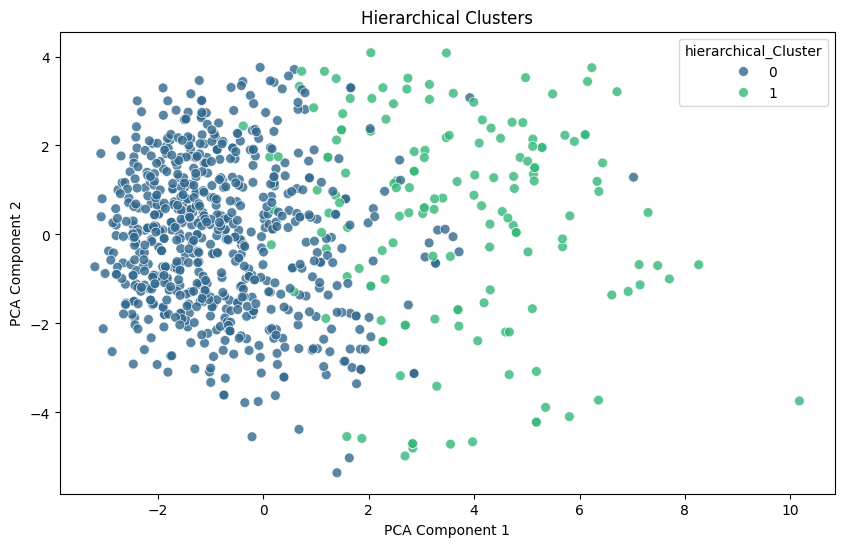

In [18]:
# @title Cluster Visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)

def plot_clusters(method_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],
                    hue=df[f'{method_name}_Cluster'], palette='viridis',
                    s=50, alpha=0.8)
    plt.title(f'{method_name.capitalize()} Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

for method in cluster_results.keys():
    plot_clusters(method)

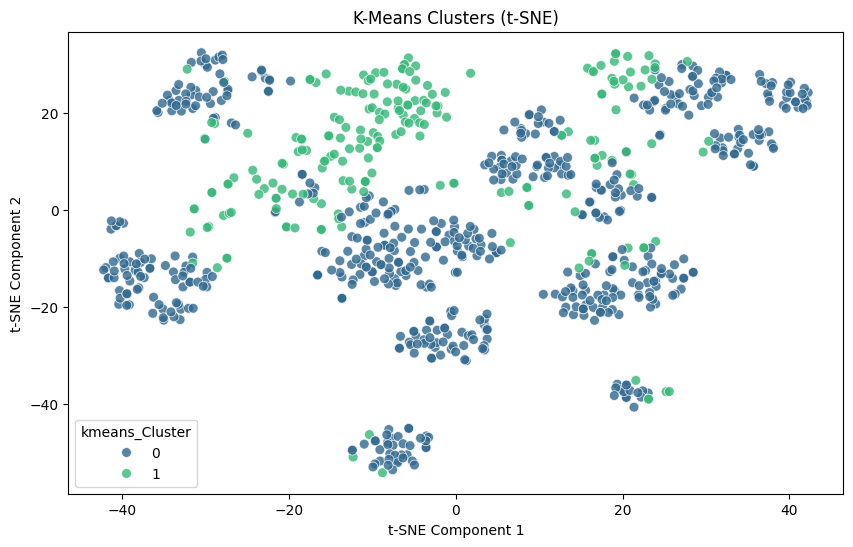

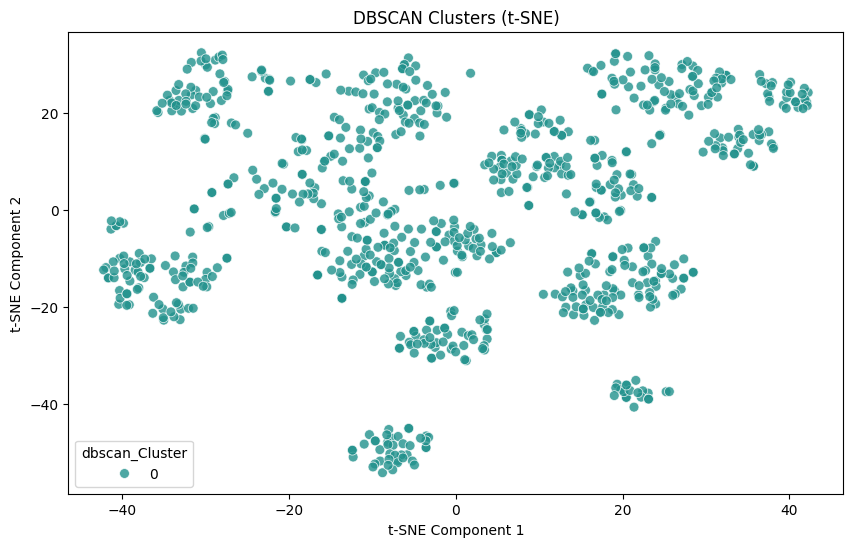

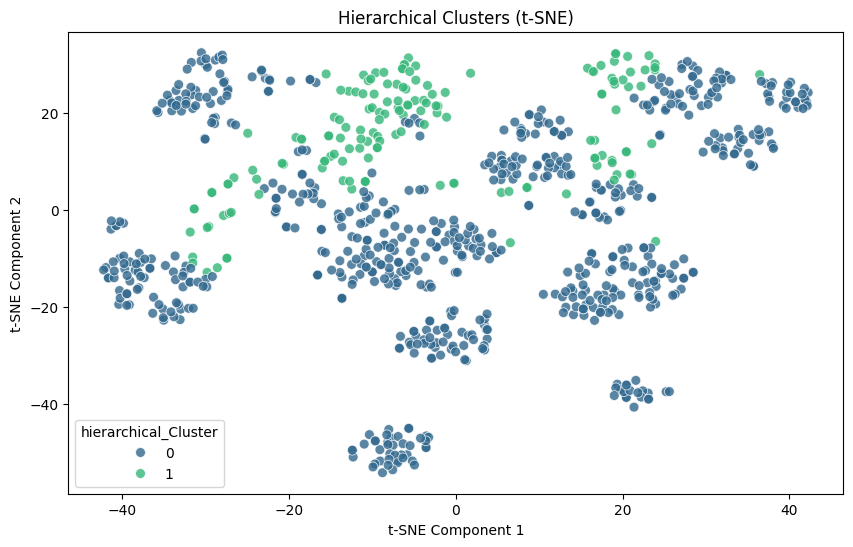

In [19]:
# @title TSNE for all the three cluster algorithms

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE for each clustering method
tsne = TSNE(n_components=2, random_state=SEED)

# K-Means
kmeans_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tsne[:, 0], y=kmeans_tsne[:, 1],
                hue=df['kmeans_Cluster'], palette='viridis',
                s=50, alpha=0.8)
plt.title('K-Means Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# DBSCAN
dbscan_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dbscan_tsne[:, 0], y=dbscan_tsne[:, 1],
                hue=df['dbscan_Cluster'], palette='viridis',
                s=50, alpha=0.8)
plt.title('DBSCAN Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Hierarchical
hierarchical_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hierarchical_tsne[:, 0], y=hierarchical_tsne[:, 1],
                hue=df['hierarchical_Cluster'], palette='viridis',
                s=50, alpha=0.8)
plt.title('Hierarchical Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [20]:
# @title Cluster Distribution Labels
print("\n Cluster Distributions:")
for method in cluster_results.keys():
    if f'{method}_Cluster_Label' in df.columns:
        print(f"\n{method.capitalize()} Clusters:")
        print(df[f'{method}_Cluster_Label'].value_counts())


 Cluster Distributions:

Kmeans Clusters:
kmeans_Cluster_Label
High-Value Customers    628
Low-Value Customers     211
Name: count, dtype: int64


In [21]:
# @title Hierarchical Clustering Parameter Tuning

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Define range of clusters to test
n_clusters_range = range(2, 10)  # Test 2 to 9 clusters
linkage_methods = ['ward', 'complete', 'average', 'single']  # Linkage methods to test

# Store results
best_score = -1
best_params = {}

#principal_components = pca.fit_transform(scaled_df)

# Grid search for best parameters
for n_clusters in n_clusters_range:
    for linkage in linkage_methods:
        agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        # Use PCA data
        labels = agglo.fit_predict(scaled_df)

        # Silhouette score requires at least 2 clusters
        if len(np.unique(labels)) > 1:
            # Use PCA data
            score = silhouette_score(scaled_df, labels)
            print(f"n_clusters: {n_clusters}, linkage: {linkage}, Silhouette Score: {score:.3f}")

            # Track the best parameters
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'linkage': linkage}

print(f"\nBest Parameters: {best_params}, Best Silhouette Score: {best_score:.3f}")

n_clusters: 2, linkage: ward, Silhouette Score: 0.175
n_clusters: 2, linkage: complete, Silhouette Score: 0.757
n_clusters: 2, linkage: average, Silhouette Score: 0.757
n_clusters: 2, linkage: single, Silhouette Score: 0.757
n_clusters: 3, linkage: ward, Silhouette Score: 0.163
n_clusters: 3, linkage: complete, Silhouette Score: 0.182
n_clusters: 3, linkage: average, Silhouette Score: 0.327
n_clusters: 3, linkage: single, Silhouette Score: 0.329
n_clusters: 4, linkage: ward, Silhouette Score: 0.105
n_clusters: 4, linkage: complete, Silhouette Score: 0.194
n_clusters: 4, linkage: average, Silhouette Score: 0.247
n_clusters: 4, linkage: single, Silhouette Score: 0.250
n_clusters: 5, linkage: ward, Silhouette Score: 0.096
n_clusters: 5, linkage: complete, Silhouette Score: 0.183
n_clusters: 5, linkage: average, Silhouette Score: 0.220
n_clusters: 5, linkage: single, Silhouette Score: 0.242
n_clusters: 6, linkage: ward, Silhouette Score: 0.098
n_clusters: 6, linkage: complete, Silhouette S

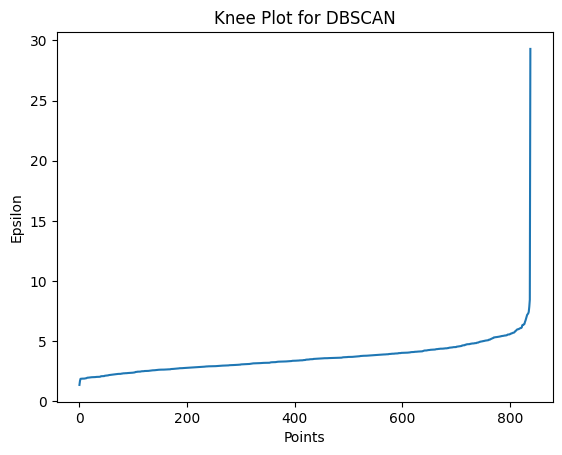

eps: 0.10, min_samples: 2, Silhouette Score: -0.206
eps: 0.10, min_samples: 3, Silhouette Score: -0.088
eps: 0.20, min_samples: 2, Silhouette Score: -0.206
eps: 0.20, min_samples: 3, Silhouette Score: -0.088
eps: 0.30, min_samples: 2, Silhouette Score: -0.206
eps: 0.30, min_samples: 3, Silhouette Score: -0.088
eps: 0.40, min_samples: 2, Silhouette Score: -0.206
eps: 0.40, min_samples: 3, Silhouette Score: -0.088
eps: 0.50, min_samples: 2, Silhouette Score: -0.206
eps: 0.50, min_samples: 3, Silhouette Score: -0.088
eps: 0.60, min_samples: 2, Silhouette Score: -0.206
eps: 0.60, min_samples: 3, Silhouette Score: -0.088
eps: 0.70, min_samples: 2, Silhouette Score: -0.206
eps: 0.70, min_samples: 3, Silhouette Score: -0.088
eps: 0.80, min_samples: 2, Silhouette Score: -0.206
eps: 0.80, min_samples: 3, Silhouette Score: -0.088
eps: 0.90, min_samples: 2, Silhouette Score: -0.206
eps: 0.90, min_samples: 3, Silhouette Score: -0.088
eps: 1.00, min_samples: 2, Silhouette Score: -0.206
eps: 1.00, m

In [22]:
# @title DBSCAN Scaled Date
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Use scaled_features instead of processed_data
processed_data = scaled_df

# Find optimal eps using the knee method
nn = NearestNeighbors(n_neighbors=5).fit(processed_data)
distances, _ = nn.kneighbors(processed_data)
distances = np.sort(distances[:, -1])

# Plot distances to find the "knee"
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Epsilon')
plt.title('Knee Plot for DBSCAN')
plt.show()

# Grid search for best parameters
best_score = -1
best_eps = 0.5  # Start with a value from the knee plot
best_min_samples = 5

for eps in np.linspace(0.1, 1.0, 10):  # Test eps values from 0.1 to 1.0
    for min_samples in range(2, 10):  # Test min_samples from 2 to 9
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(processed_data)

        # Silhouette score requires at least 2 clusters
        if len(np.unique(labels)) > 1:
            score = silhouette_score(processed_data, labels)
            print(f"eps: {eps:.2f}, min_samples: {min_samples}, Silhouette Score: {score:.3f}")

            # Track the best parameters
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"\nBest eps: {best_eps:.2f}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score:.3f}")


In [23]:
# @title Fine tuning

import numpy as np
# @title Fine-tuning Clustering Algorithms
def fine_tune_kmeans(scaled_df):
    """Fine-tunes KMeans clustering."""
    best_score = -1
    best_kmeans = None
    for n_clusters in range(2, 6):  # Try different numbers of clusters
        for init in ['k-means++', 'random']:  # Try different initialization methods
            for max_iter in [300, 500]:  # Try different maximum iterations
                kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=max_iter, random_state=SEED)
                kmeans_labels = kmeans.fit_predict(scaled_df)
                silhouette_avg = silhouette_score(scaled_df, kmeans_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_kmeans = kmeans
    return best_kmeans

def fine_tune_dbscan(scaled_df):
    """Fine-tunes DBSCAN clustering."""
    best_score = -1
    best_dbscan = None
    for eps in np.linspace(0.5, 5, 10):  # Try different epsilon values
        for min_samples in range(5, 15):  # Try different minimum samples
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(scaled_df)
            if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster is found
                silhouette_avg = silhouette_score(scaled_df, dbscan_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_dbscan = dbscan
    return best_dbscan

def fine_tune_hierarchical(scaled_df):
    """Fine-tunes Hierarchical clustering."""
    best_score = -1
    best_agg = None
    for n_clusters in range(2, 6):  # Try different numbers of clusters
        for linkage in ['ward', 'complete', 'average']:  # Try different linkage methods
            agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            agg_labels = agg.fit_predict(scaled_df)
            silhouette_avg = silhouette_score(scaled_df, agg_labels)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_agg = agg
    return best_agg


# Fine-tune the clustering algorithms
best_kmeans = fine_tune_kmeans(scaled_df)
best_dbscan = fine_tune_dbscan(scaled_df)
best_agg = fine_tune_hierarchical(scaled_df)

# Use the best models for clustering
kmeans_labels = best_kmeans.fit_predict(scaled_df)
dbscan_labels = best_dbscan.fit_predict(scaled_df)
agg_labels = best_agg.fit_predict(scaled_df)

# Evaluate and analyze the results of the fine-tuned models
print("KMeans Silhouette Score:", silhouette_score(scaled_df, kmeans_labels))
print("DBSCAN Silhouette Score:", silhouette_score(scaled_df, dbscan_labels))
print("Hierarchical Silhouette Score:", silhouette_score(scaled_df, agg_labels))

KMeans Silhouette Score: 0.1954625987689091
DBSCAN Silhouette Score: 0.17400110478878414
Hierarchical Silhouette Score: 0.757316061138377


In [24]:
# @title Cluster Characterization (Fine-Tuned Models)
def characterize_clusters_tuned(labels, method_name, scaled_df):
    df[f'{method_name}_Cluster'] = labels
    # Select only numeric columns for the mean calculation
    numeric_cols = df.select_dtypes(include=np.number).columns
    cluster_profile = df.groupby(f'{method_name}_Cluster')[numeric_cols].mean()
    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])
    return cluster_profile

# Characterize fine-tuned models
characterize_clusters_tuned(kmeans_labels, 'kmeans_tuned', scaled_df)
characterize_clusters_tuned(dbscan_labels, 'dbscan_tuned', scaled_df)
characterize_clusters_tuned(agg_labels, 'hierarchical_tuned', scaled_df)



Kmeans_tuned Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
kmeans_tuned_Cluster                                              
0                     32617.591561   21.144904        12.116242   
1                     42255.113744  101.218009        47.649289   

                      NumDealsPurchases  NumWebPurchases  
kmeans_tuned_Cluster                                      
0                              1.689490         1.573248  
1                              2.867299         3.668246  

Dbscan_tuned Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
dbscan_tuned_Cluster                                              
-1                    43020.619718  104.352113        60.253521   
 0                    34904.694522   37.313202        18.146067   
 1                    20604.300000    2.700000         7.150000   
 2                    41806.125000   34.500000        11.187500   

                      NumDea

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Tenure,Hierarchical_Cluster,kmeans_Cluster,dbscan_Cluster,hierarchical_Cluster,kmeans_tuned_Cluster,dbscan_tuned_Cluster,hierarchical_tuned_Cluster
hierarchical_tuned_Cluster,,,,,,,,,,,,,,,,,,,,,
0,1970.934368,35042.363365,0.782816,0.494033,51.201671,41.325776,4.278043,21.048926,6.042959,3.979714,...,0.0,0.0,312.756563,-0.454654,0.250597,0.0,0.186158,0.250597,0.002387,0.0
1,1988.000000,34176.000000,1.000000,0.000000,12.000000,5.000000,7.000000,24.000000,19.000000,14.000000,...,0.0,0.0,48.000000,2.000000,1.000000,0.0,0.000000,1.000000,-1.000000,1.0


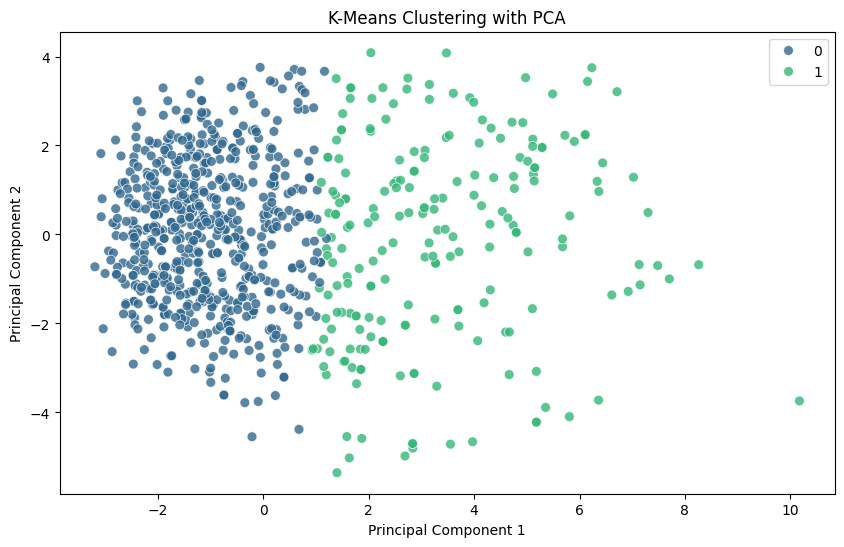

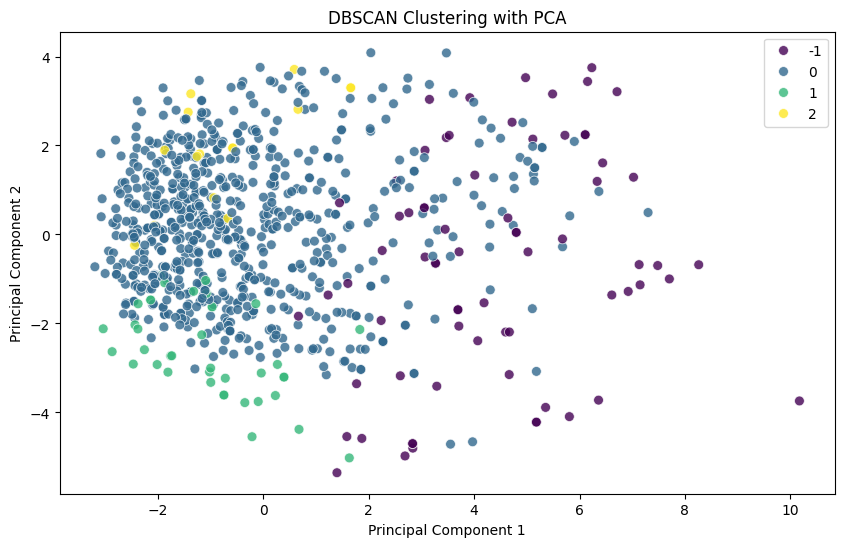

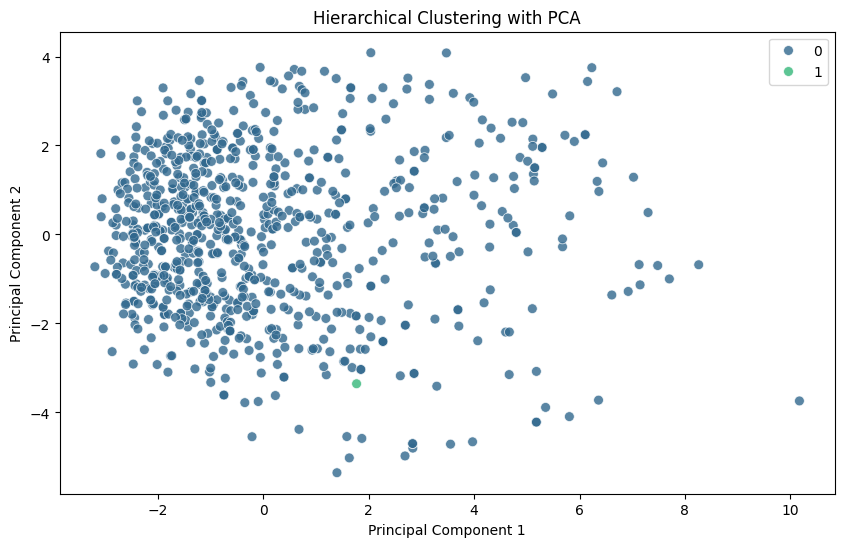

In [25]:
import matplotlib.pyplot as plt
# @title Visualize Clusters (Fine-Tuned Models)

def plot_clusters_pca(df, labels, method_name, title):
    """Plots clusters using PCA for dimensionality reduction."""
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],
                    hue=labels, palette='viridis', s=50, alpha=0.8)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Assuming you have the labels for each method
plot_clusters_pca(scaled_df, kmeans_labels, 'K-Means', 'K-Means Clustering with PCA')
plot_clusters_pca(scaled_df, dbscan_labels, 'DBSCAN', 'DBSCAN Clustering with PCA')
plot_clusters_pca(scaled_df, agg_labels, 'Hierarchical', 'Hierarchical Clustering with PCA')


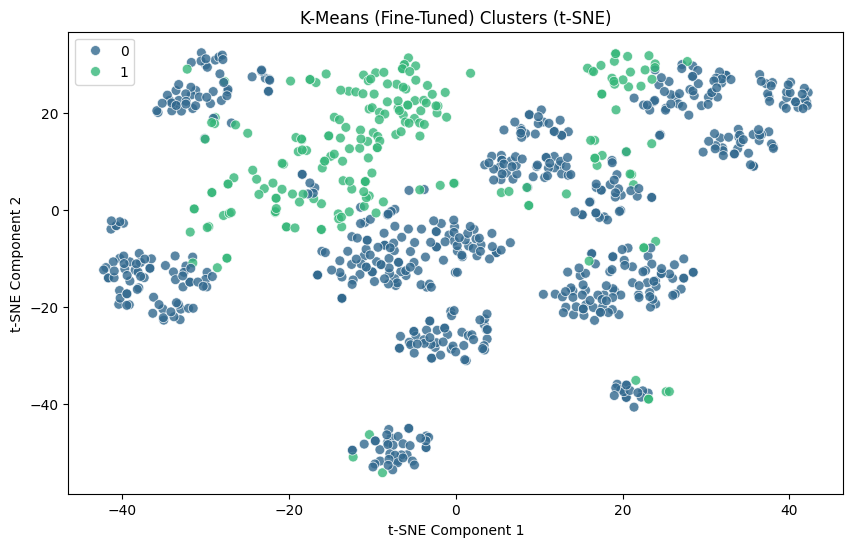

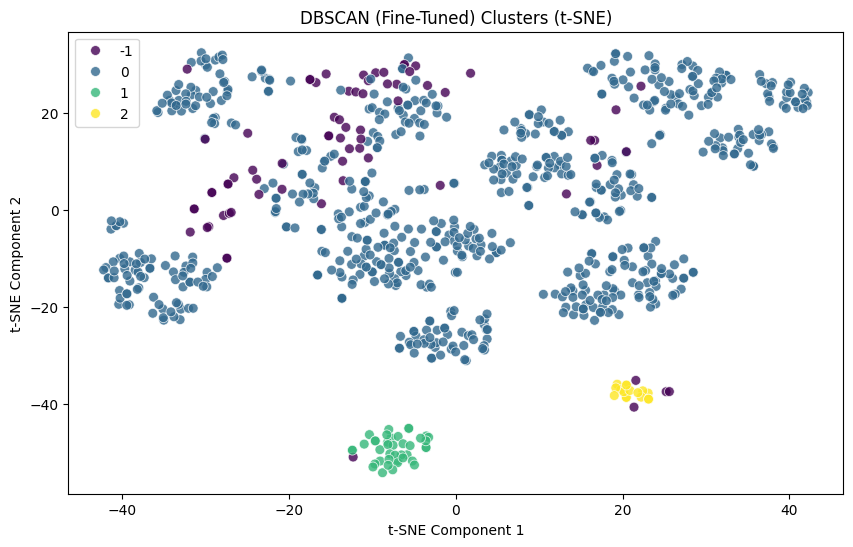

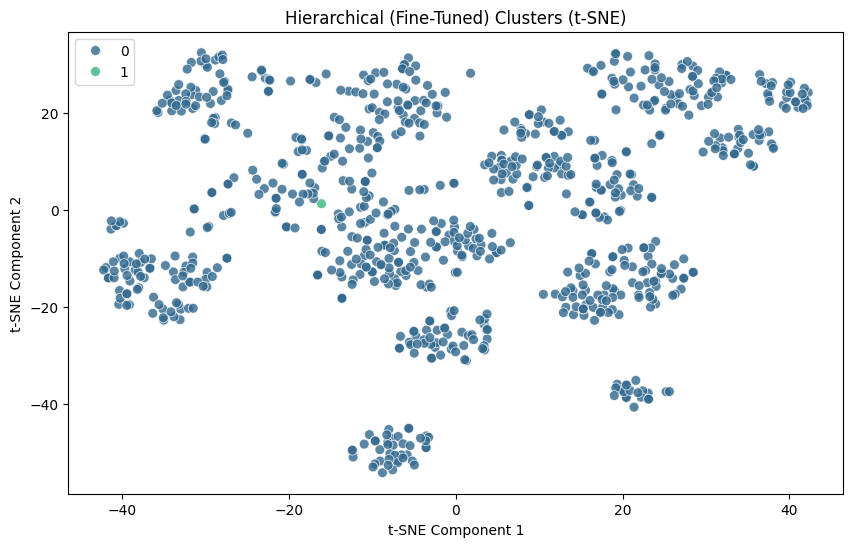

In [26]:
# @title TSNE for Fine-Tuned Models

import matplotlib.pyplot as plt
# Perform t-SNE for each fine-tuned clustering method
tsne = TSNE(n_components=2, random_state=SEED)

# K-Means (Fine-tuned)
kmeans_tuned_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tuned_tsne[:, 0], y=kmeans_tuned_tsne[:, 1],
                hue=kmeans_labels, palette='viridis',
                s=50, alpha=0.8)
plt.title('K-Means (Fine-Tuned) Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# DBSCAN (Fine-tuned)
dbscan_tuned_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dbscan_tuned_tsne[:, 0], y=dbscan_tuned_tsne[:, 1],
                hue=dbscan_labels, palette='viridis',
                s=50, alpha=0.8)
plt.title('DBSCAN (Fine-Tuned) Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Hierarchical (Fine-tuned)
hierarchical_tuned_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hierarchical_tuned_tsne[:, 0], y=hierarchical_tuned_tsne[:, 1],
                hue=agg_labels, palette='viridis',
                s=50, alpha=0.8)
plt.title('Hierarchical (Fine-Tuned) Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()



Kmeans Cluster Labels:


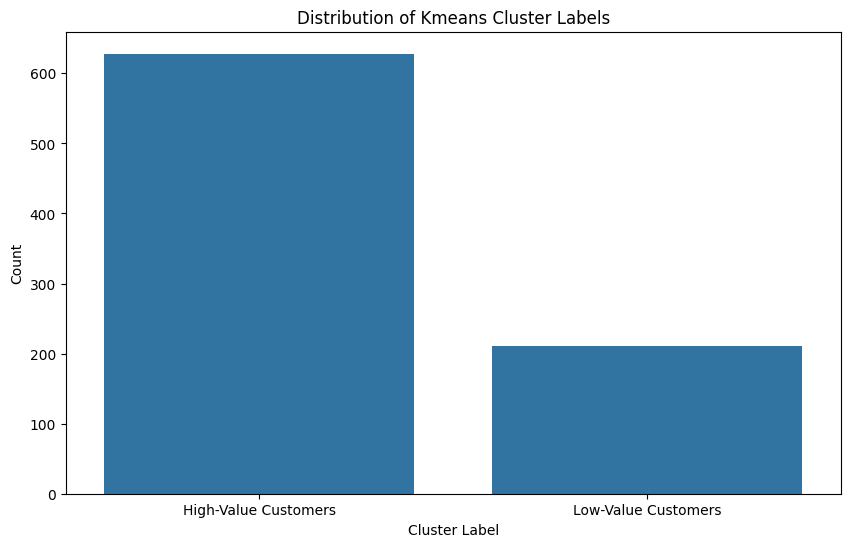

kmeans_Cluster_Label
High-Value Customers    628
Low-Value Customers     211
Name: count, dtype: int64


In [27]:
# @title Cluster Distributions and Labels

import matplotlib.pyplot as plt
# Assuming df is your DataFrame and cluster_results contains the labels for each method

def plot_cluster_distribution_labels(method_name):
  """Plots the distribution of cluster labels for a given clustering method."""
  if f'{method_name}_Cluster_Label' in df.columns:
    print(f"\n{method_name.capitalize()} Cluster Labels:")
    plt.figure(figsize=(10, 6))
    sns.countplot(x=f'{method_name}_Cluster_Label', data=df)
    plt.title(f'Distribution of {method_name.capitalize()} Cluster Labels')
    plt.xlabel('Cluster Label')
    plt.ylabel('Count')
    plt.show()
    print(df[f'{method_name}_Cluster_Label'].value_counts())

# Plot cluster distributions and labels for KMeans
plot_cluster_distribution_labels('kmeans')

# Plot cluster distributions and labels for DBSCAN
plot_cluster_distribution_labels('dbscan')

# Plot cluster distributions and labels for Hierarchical
plot_cluster_distribution_labels('hierarchical')


In [28]:
# @title Save the Results
# Save the clustered data to a new CSV file
df.to_csv('clustered_data.csv', index=False)

print("Clustered data saved to 'clustered_data.csv'.")

Clustered data saved to 'clustered_data.csv'.


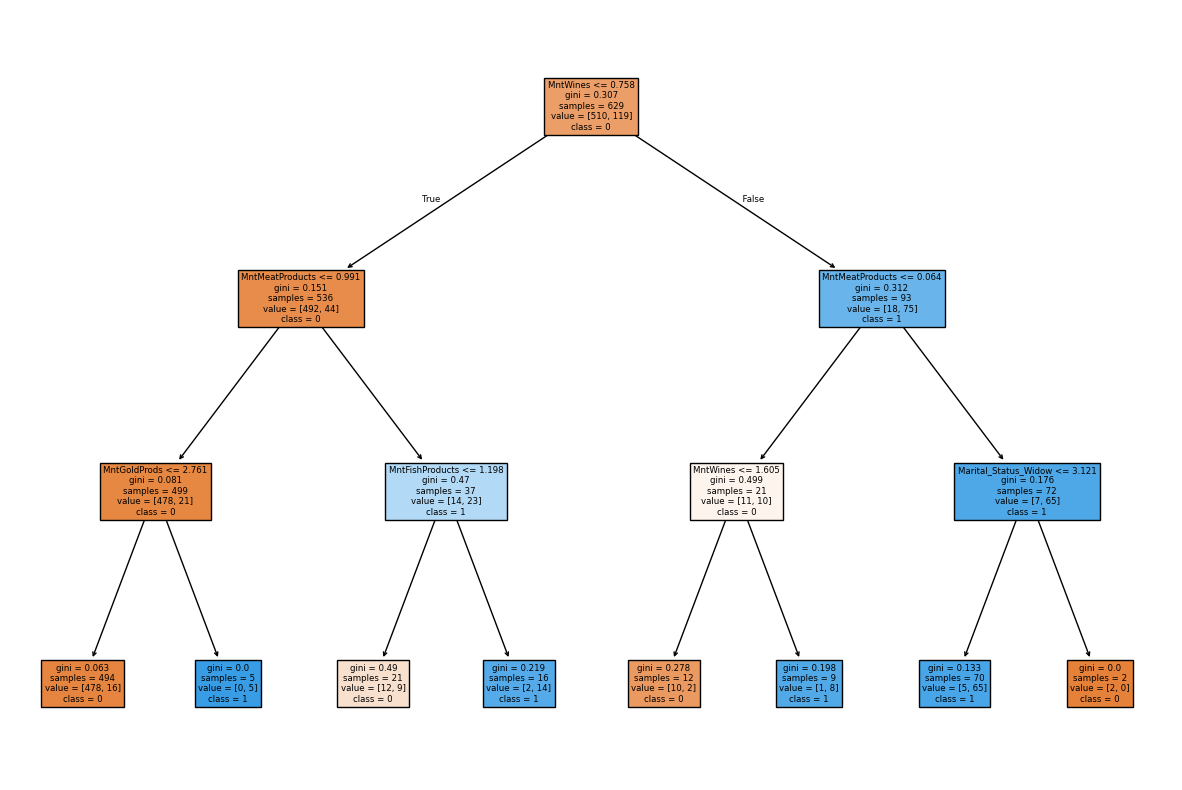

Decision Tree Accuracy: 0.943


In [29]:
# @title Use decision trees to explain cluster drivers.

import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Assuming 'df' contains your data with cluster labels
# and 'scaled_df' contains your scaled data

# Choose the clustering method you want to explain (e.g., 'hierarchical')
cluster_method = 'hierarchical'

# Create a target variable indicating the cluster label
y = df[f'{cluster_method}_Cluster']

# Select features for the decision tree
# You might want to choose features that you think are important for understanding clusters
X = scaled_df  # You can select specific features from scaled_df if needed

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)  # Adjust max_depth as needed

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, feature_names=scaled_df.columns, class_names=np.unique(y).astype(str), filled=True)
plt.show()

# Evaluate the performance of the decision tree
from sklearn.metrics import accuracy_score
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.3f}")



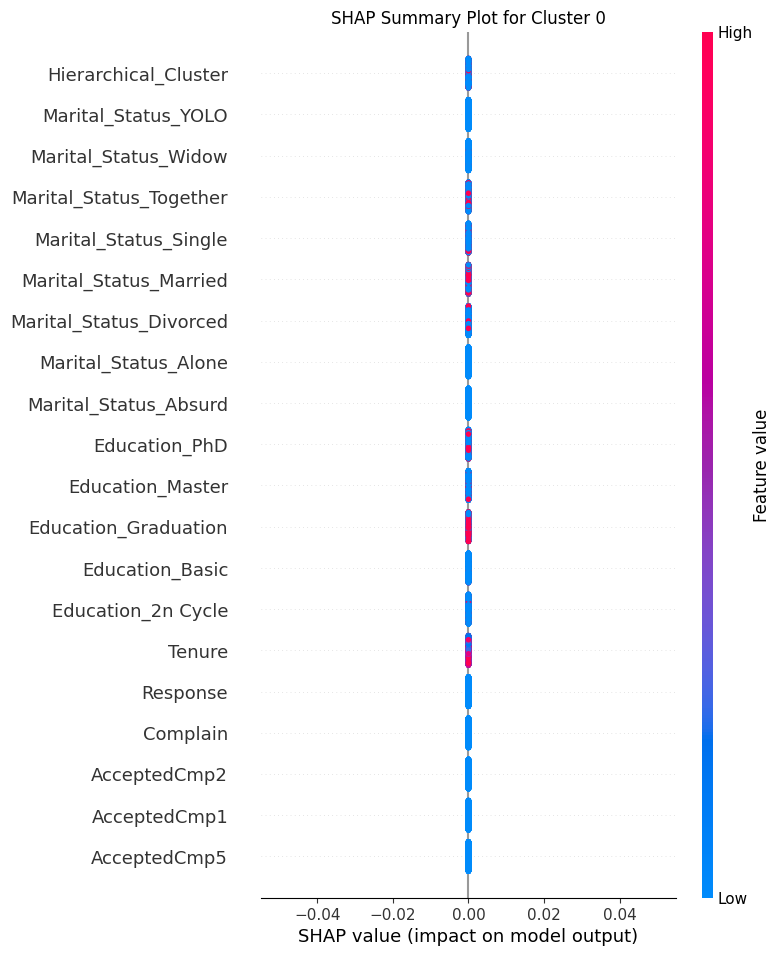

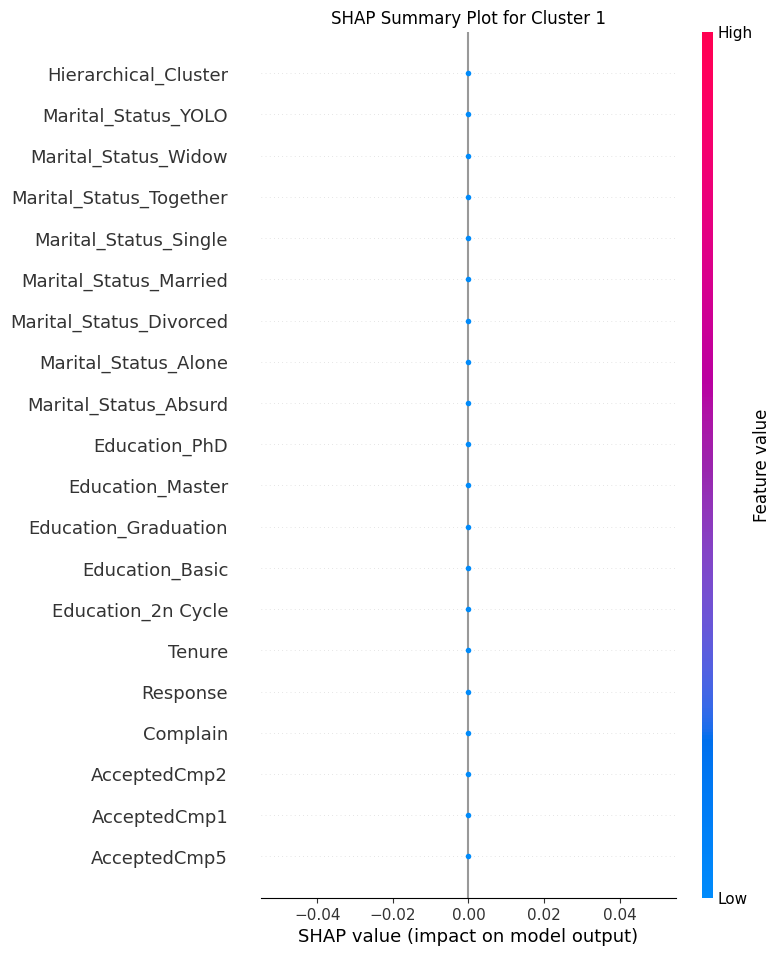

In [30]:
# @title SHAP values to explain cluster drivers.

import matplotlib.pyplot as plt
import numpy as np
!pip install shap

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Instead of directly using AgglomerativeClustering with SHAP, we will train a supervised model (RandomForest) to predict the cluster labels
# and then use SHAP to explain this supervised model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_df, agg_labels, test_size=0.25, random_state=42)

# Train a RandomForestClassifier to predict cluster labels
surrogate_model = RandomForestClassifier(random_state=42)
surrogate_model.fit(X_train, y_train)

# Create a TreeExplainer for the surrogate model
explainer = shap.TreeExplainer(surrogate_model)

# Calculate SHAP values for the scaled data
shap_values = explainer.shap_values(scaled_df)

# Plot the SHAP summary plot for each cluster
for cluster_label in np.unique(agg_labels):
  cluster_data = scaled_df[agg_labels == cluster_label]
  shap_cluster = explainer.shap_values(cluster_data) #Calculate SHAP values for this specific cluster
  shap.summary_plot(shap_cluster, cluster_data, show=False)
  plt.title(f'SHAP Summary Plot for Cluster {cluster_label}')
  plt.show()


# You can further explore individual feature contributions for specific data points within each cluster
shap.force_plot(explainer.expected_value, shap_values[0,:], scaled_df.iloc[0,:])